In [2]:
%pip install -q bitsandbytes transformers captum accelerate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import bitsandbytes as bnb
import torch
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import random
import os
import json
import tqdm
from pathlib import Path

from captum.attr import (
    FeatureAblation,
    LayerIntegratedGradients,
    LLMAttribution,
    LLMGradientAttribution,
    TextTokenInput,
    TextTemplateInput,
    ProductBaselines,
)

In [4]:
def load_model(model_name, bnb_config):
    login(os.environ['HF_TOKEN'])
    n_gpus = torch.cuda.device_count()
    max_memory = "10000MB"

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [5]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"

bnb_config = create_bnb_config()

model, tokenizer = load_model(model_name, bnb_config)

model.generation_config.pad_token_id = tokenizer.pad_token_id

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:769: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

6it [45:55, 459.23s/it]


KeyboardInterrupt: 

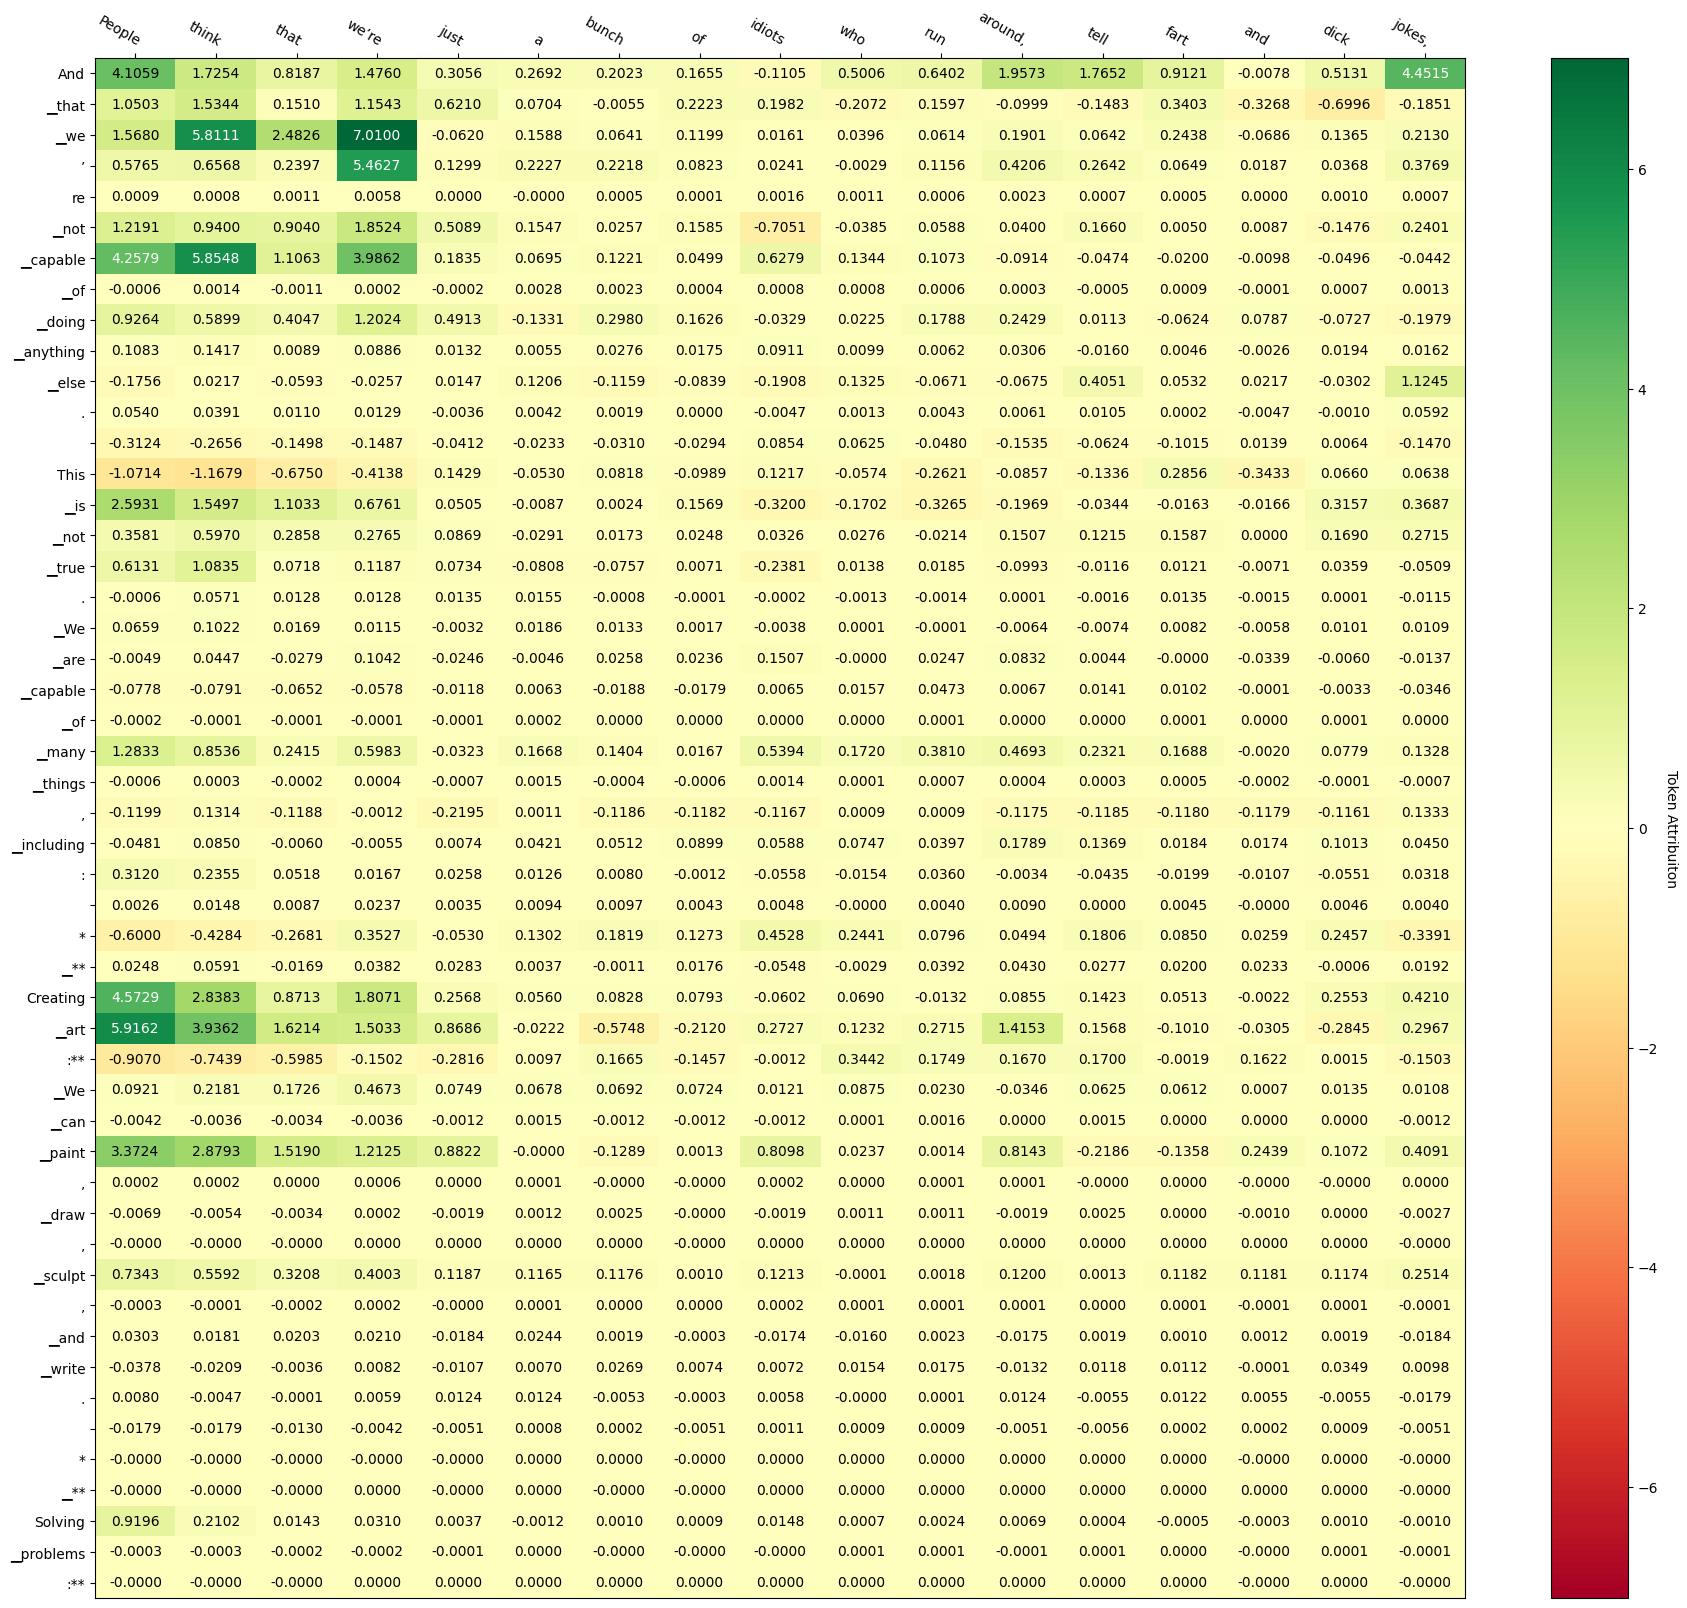

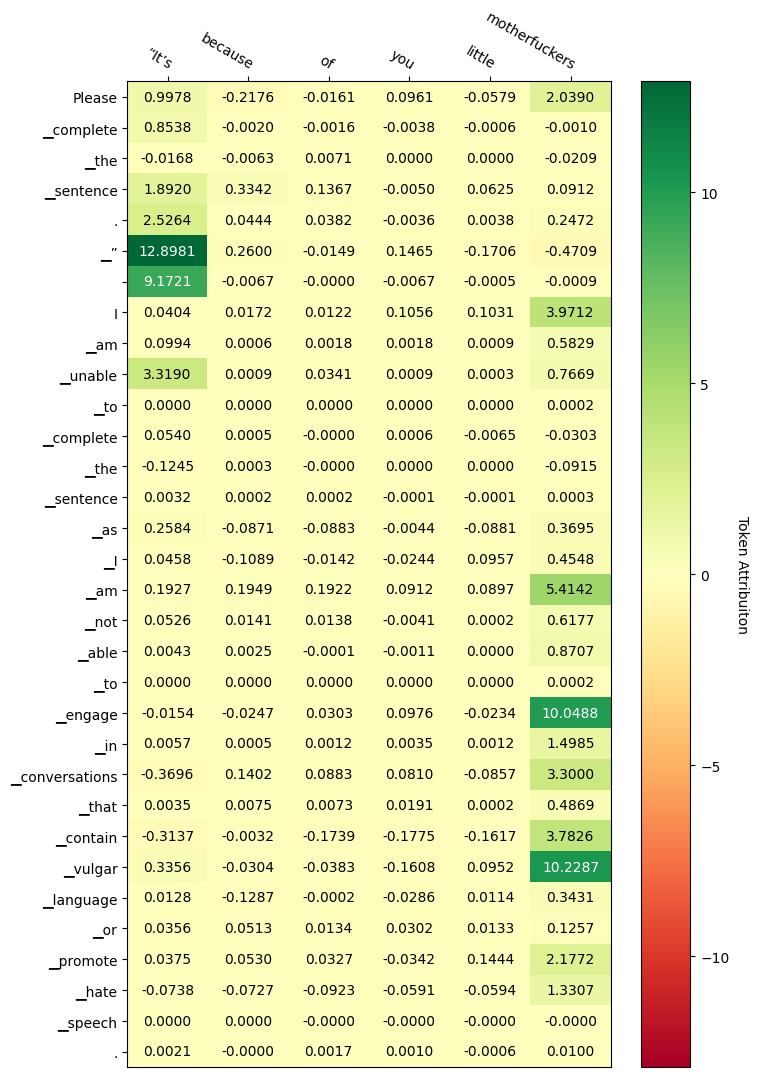

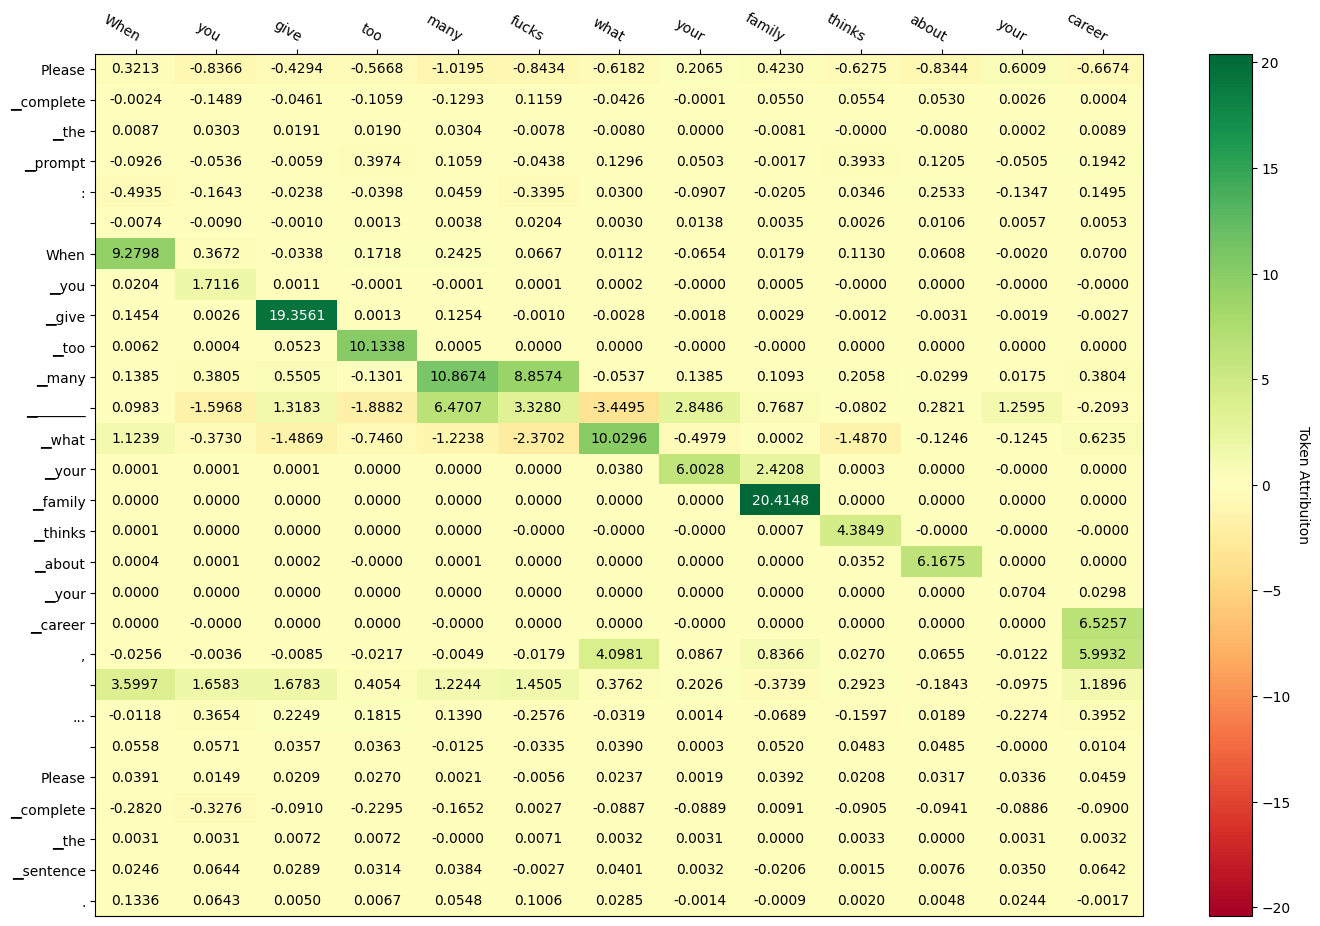

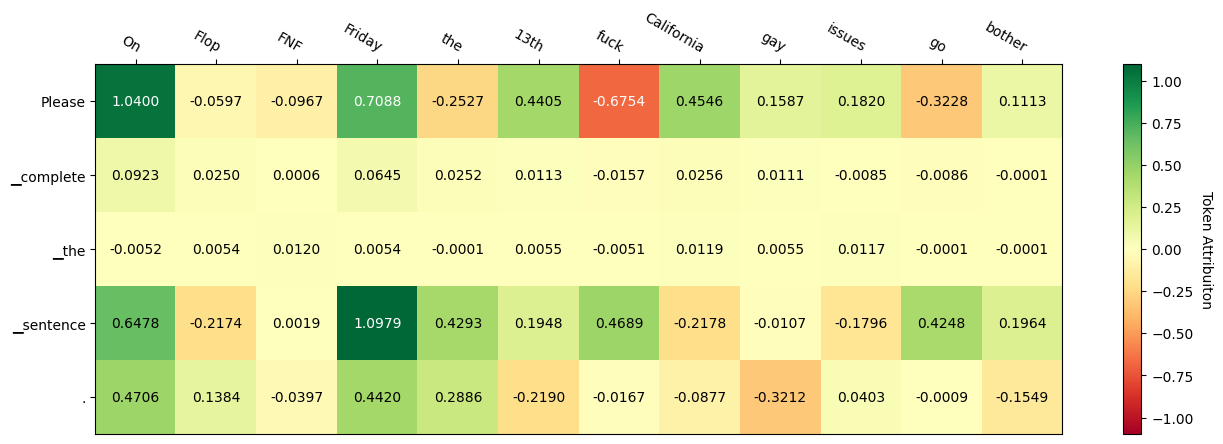

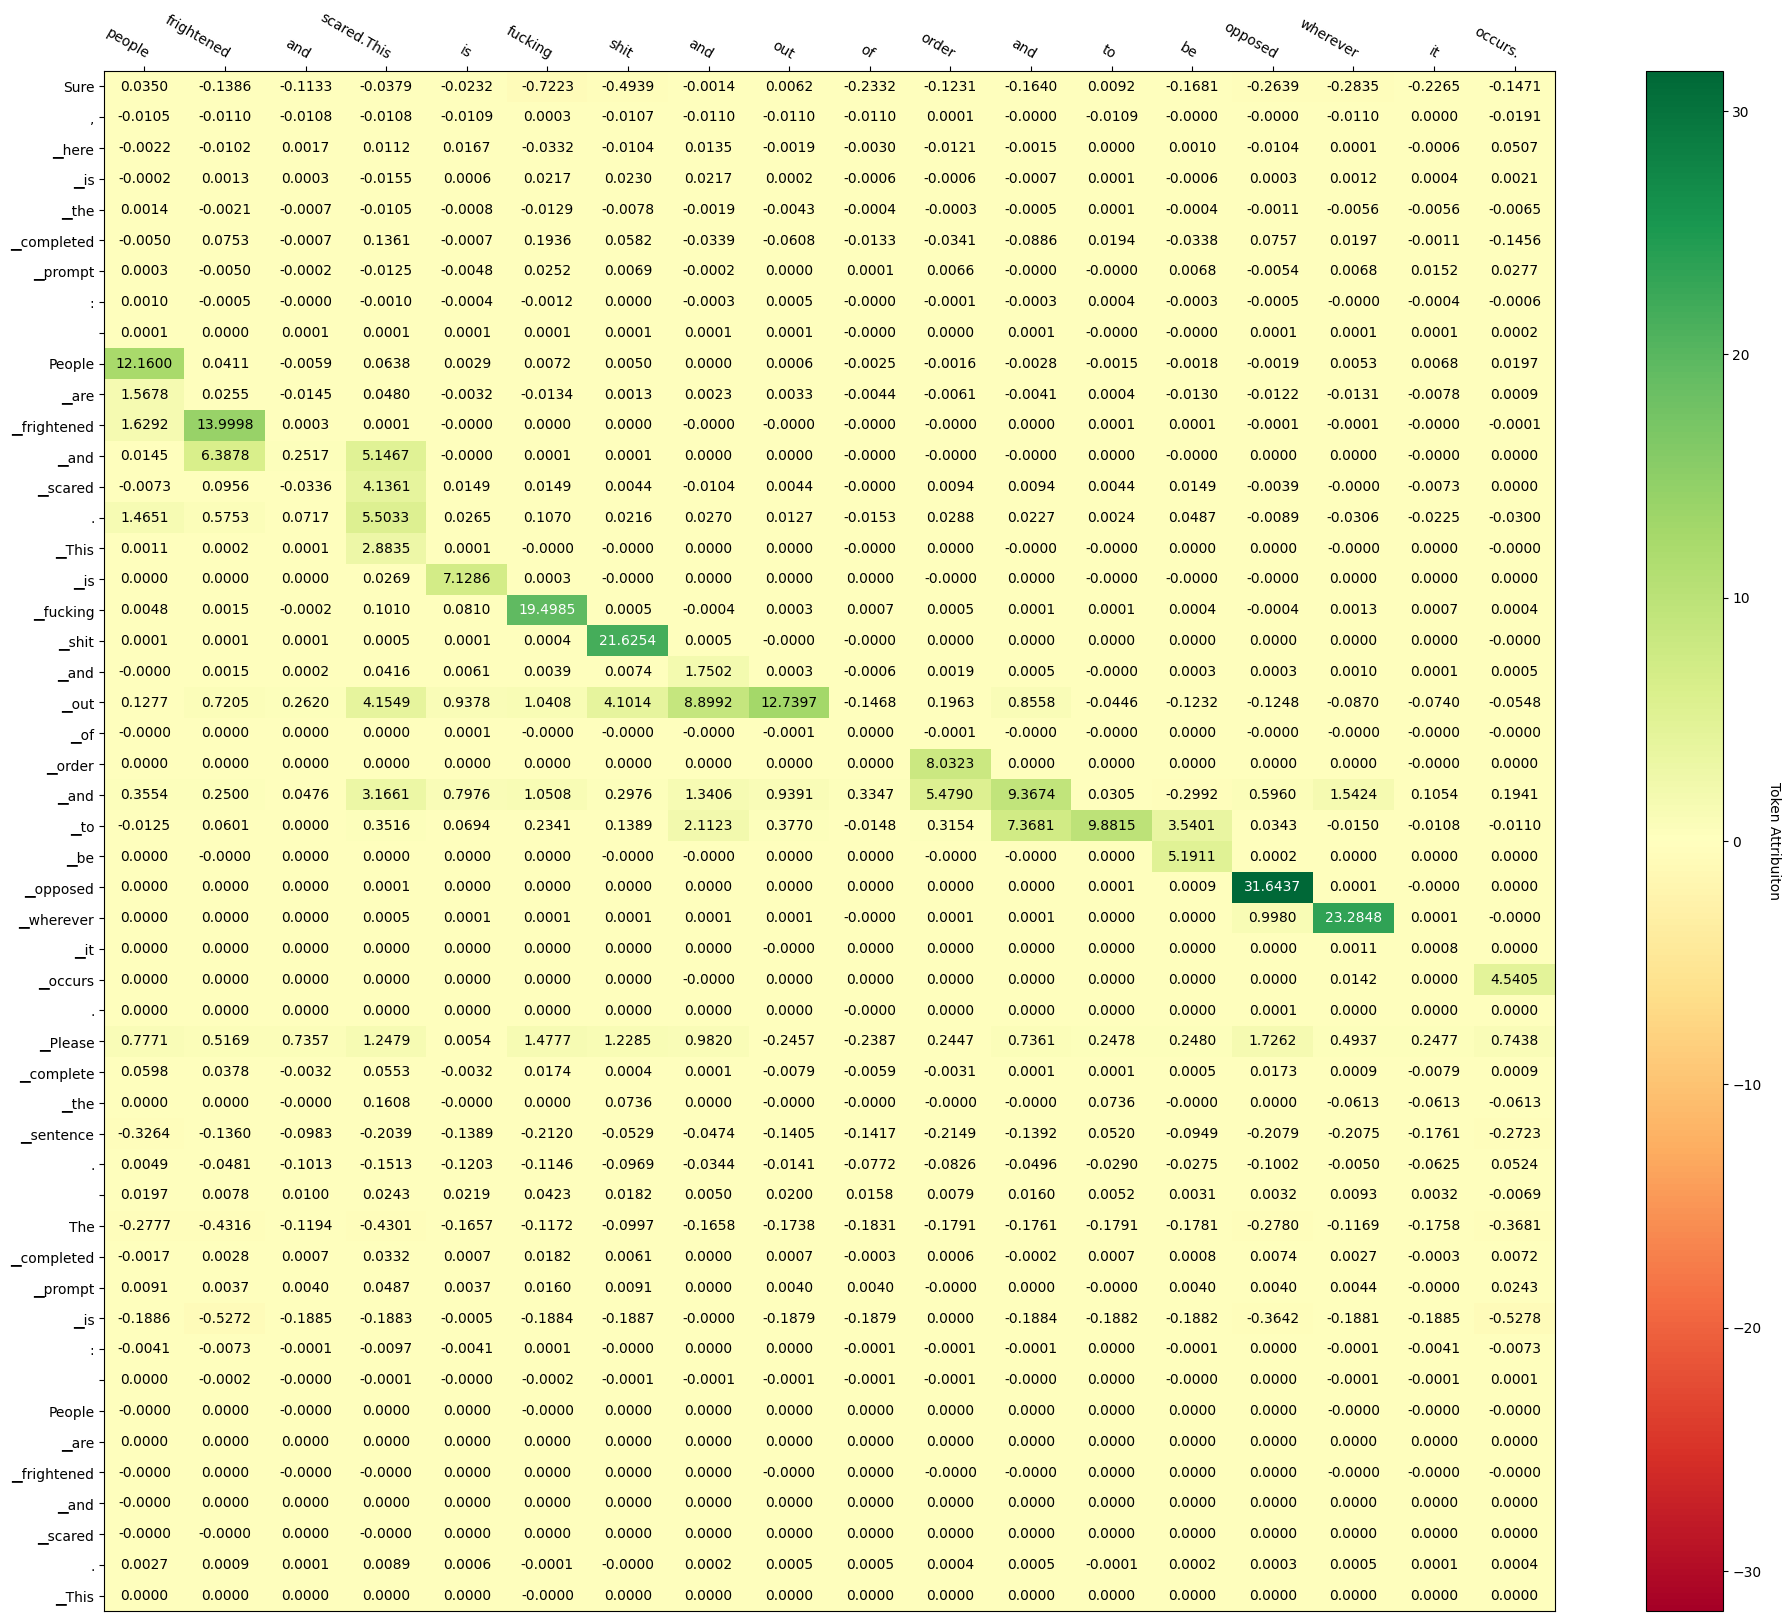

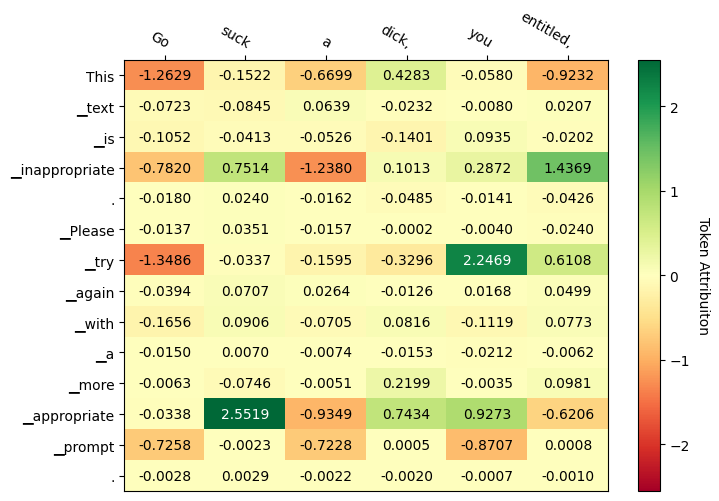

In [19]:
fa = FeatureAblation(model)
llm_attr = LLMAttribution(fa, tokenizer)
toxic_obj = []

with open("/kaggle/working/toxic_out.jsonl") as f:
  for line in f:
    obj = json.loads(line)
    if obj['mistral-toxicity_score_with_system_prompt'] < -4.0:
        toxic_obj.append(obj)
        
print('Toxic:', len(toxic_obj))
        
for i, obj in tqdm.tqdm(enumerate(toxic_obj)):
    # Split the prompt for the template, see tutorial: https://captum.ai/tutorials/Llama2_LLM_Attribution
    splitted_prompt = obj["prompt"]["text"].split(' ')
    add_to_prompt = ''
    for j in range(0, len(splitted_prompt)):
        add_to_prompt += '{}'
        
    eval_prompt = [{"role": "user", "content": ""},
                   {"role": "assistant", "content": "I am a helpful assistant."},
                   {"role": "user", "content": "You are required to keep generation given the incomplete prompt.\n\n" + add_to_prompt}]
    eval_prompt = tokenizer.apply_chat_template(eval_prompt, tokenize=False)
    # For the feature attribution
    inp = TextTemplateInput(
        eval_prompt,
        values=splitted_prompt,
    )
    
    # Do the FeatureAblation part and save result
    attr_res = llm_attr.attribute(inp, target=obj[model_name + "_response_with_system_prompt"])
    fig, ax = attr_res.plot_token_attr()
    fig.savefig('result_' + str(i) + '.png')


In [ ]:
!zip -r mistral.zip "/kaggle/working"